In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import text_recognizer
except ImportError:
    import sys
    sys.path.append('..')

from text_recognizer.datasets import IamDataset
from text_recognizer.datasets import IamParagraphsDataset
from text_recognizer.models import LineDetectorModel
from text_recognizer import util

In [2]:
paragraphs_dataset = IamParagraphsDataset()
paragraphs_dataset.load_or_generate_data()
print(paragraphs_dataset)

Loading IAM paragraph crops and ground truth from image files...
IAM Paragraphs Dataset
Num classes: 3
Train: (1229, 256, 256) (1229, 256, 256, 3)
Test: (308, 256, 256) (308, 256, 256, 3)



In [3]:
paragraphs_dataset.x_train[0].max()

0.63529414

In [4]:
line_detector_model = LineDetectorModel()
line_detector_model.load_weights()

In [12]:
gt.shape

(256, 256)

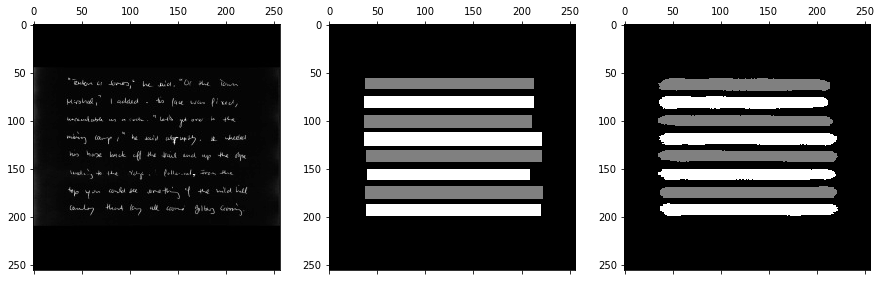

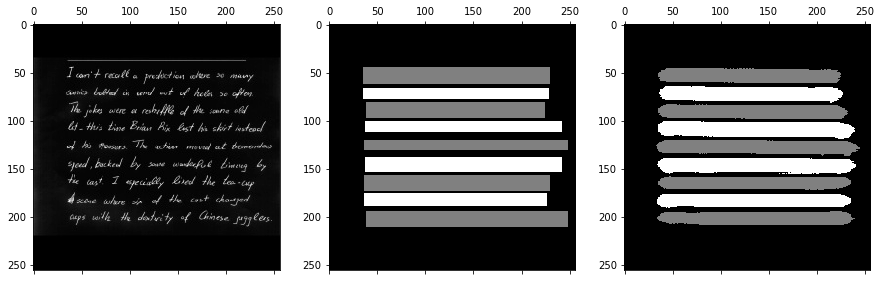

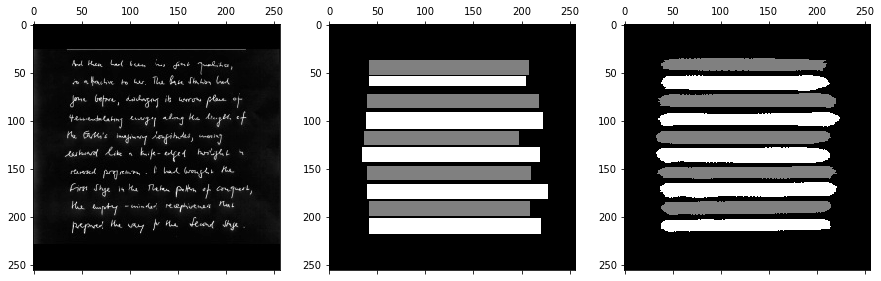

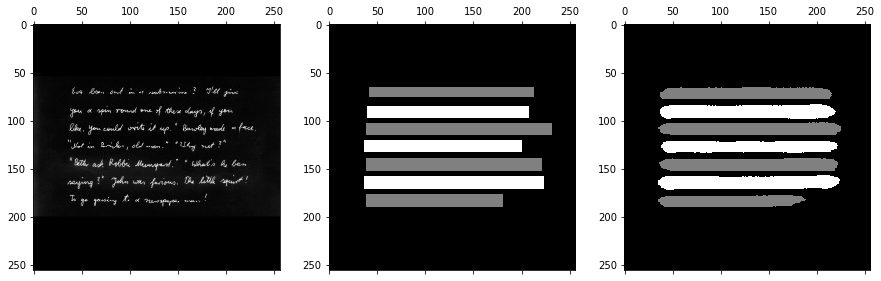

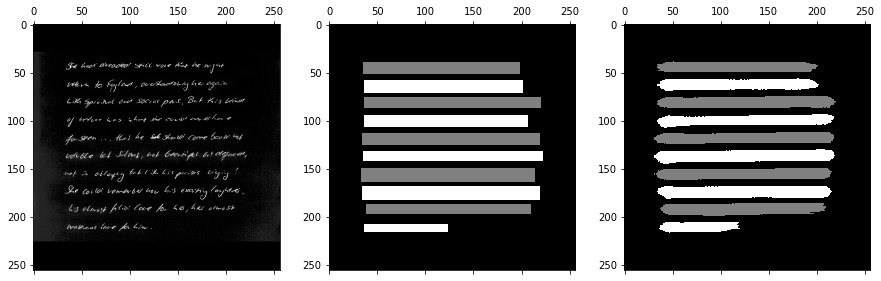

In [5]:
# Let's look at some test images, ground truth, and predictions

for ind in range(5):
    image = paragraphs_dataset.x_test[ind]
    gt = paragraphs_dataset.y_test[ind].argmax(-1)
    pred = line_detector_model.predict_on_image(image).argmax(0)
    
    accuracy.append((gt==pred).sum()/gt.shape[0]/gt.shape[1])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    ax1.matshow(image, cmap='gray')
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt, cmap='gray')
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred, cmap='gray')



In [ ]:
# 

In [7]:
import os
def read_image(image_uri, grayscale=False) -> np.array:
    """Read image_uri."""
    def read_image_from_filename(image_filename, imread_flag):
        return cv2.imread(str(image_filename), imread_flag)

    def read_image_from_url(image_url, imread_flag):
        url_response = urlopen(str(image_url))  # nosec
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        return cv2.imdecode(img_array, imread_flag)

    imread_flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    local_file = os.path.exists(image_uri)
    try:
        img = None
        if local_file:
            img = read_image_from_filename(image_uri, imread_flag)
        else:
            img = read_image_from_url(image_uri, imread_flag)
        assert img is not None
    except Exception as e:
        raise ValueError("Could not load image at {}: {}".format(image_uri, e))
    return img


In [55]:
from typing import List, Union

In [30]:
import cv2

def _resize_image_for_line_detector_model(image: np.ndarray, max_shape):
    """Resize the image to less than the max_shape while maintaining aspect ratio."""
    scale_down_factor = max(np.array(image.shape) / np.array(max_shape))
    if scale_down_factor == 1:
        return image.copy(), scale_down_factor
    resized_image = cv2.resize(image,
                               dsize=None,
                               fx=1/scale_down_factor,
                               fy=1/scale_down_factor,
                               interpolation=cv2.INTER_AREA)
    return resized_image, scale_down_factor
    

def _prepare_image_for_line_detector_model(image: np.ndarray):
    """Convert uint8 image to float image with black background with shape self.line_detector_model.image_shape."""
    resized_image, scale_down_factor = _resize_image_for_line_detector_model(
        image=image,
        max_shape=line_detector_model.image_shape
    )
    resized_image = (1. - resized_image / 255).astype('float32')
    return resized_image, scale_down_factor

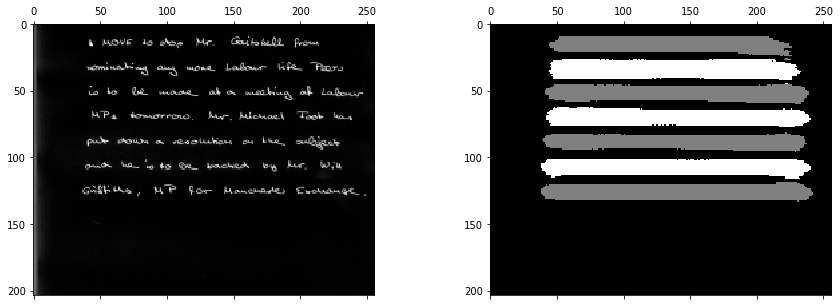

In [158]:
fn = '/home/pagpires/PROJECT/text_recognizer_pytorch/core/text_recognizer/tests/support/iam_paragraphs/a01-000u-cropped.jpg'
image = read_image(fn, grayscale=True)
image, scale_factor = _prepare_image_for_line_detector_model(image)

pred = line_detector_model.predict_on_image(image)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.matshow(image, cmap='gray')
ax2 = fig.add_subplot(122)
ax2.matshow(pred.argmax(axis=0), cmap='gray')

In [159]:
def _find_line_bounding_boxes(line_segmentation: np.ndarray):
    """Given a line segmentation, find bounding boxes for connected-component regions corresponding to non-0 labels."""

    def _find_line_bounding_boxes_in_channel(line_segmentation_channel: np.ndarray) -> np.ndarray:
        line_activation_image = cv2.dilate(line_segmentation_channel, kernel=np.ones((3, 3)), iterations=1)
        line_activation_image = (line_activation_image * 255).astype('uint8')
        line_activation_image = cv2.threshold(line_activation_image, 0.5, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        bounding_cnts, _ = cv2.findContours(line_activation_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return np.array([cv2.boundingRect(cnt) for cnt in bounding_cnts])

    bboxes_xywh = np.concatenate([
        _find_line_bounding_boxes_in_channel(line_segmentation[:, :, i])
        for i in [1, 2]
    ], axis=0)
    return bboxes_xywh[np.argsort(bboxes_xywh[:, 1])]

def _get_line_region_crops(image: np.ndarray, min_crop_len_factor: float = 0.02) -> List[np.ndarray]:
    """Find all the line regions in square image and crop them out and return them."""
    prepared_image, scale_down_factor = _prepare_image_for_line_detector_model(image)
    line_segmentation = line_detector_model.predict_on_image(prepared_image)
    # @@@ swap dim_channel to last
    line_segmentation = np.transpose(np.exp(line_segmentation), (1,2,0))
    bounding_boxes_xywh = _find_line_bounding_boxes(line_segmentation)

    bounding_boxes_xywh = (bounding_boxes_xywh * scale_down_factor).astype(int)

    min_crop_length = int(min_crop_len_factor * min(image.shape[0], image.shape[1]))
    line_region_crops = [
        image[y:y+h, x:x+w]
        for x, y, w, h in bounding_boxes_xywh
        if w >= min_crop_length and h >= min_crop_length
    ]
    return line_region_crops

In [160]:
fn = '/home/pagpires/PROJECT/text_recognizer_pytorch/core/text_recognizer/tests/support/iam_paragraphs/a01-000u-cropped.jpg'
image = read_image(fn, grayscale=True)
line_region_crops = _get_line_region_crops(image)

In [161]:
len(line_region_crops)

7

there are 18 crops but it's OK since some crops wont' have text

### line predictor

In [51]:
from text_recognizer.models import LineModel
from text_recognizer.datasets import IamLinesDataset
line_predictor_model = LineModel(dataset_cls=IamLinesDataset)
line_predictor_model.load_weights()

In [87]:
def _prepare_image_for_line_predictor_model(image: np.ndarray) -> np.ndarray:
    """
    Convert uint8 image to float image with black background with shape self.line_predictor_model.image_shape
    while maintaining the image aspect ratio.
    """
    expected_shape = line_predictor_model.image_shape
    scale_factor = (np.array(expected_shape) / np.array(image.shape)).min()
    scaled_image = cv2.resize(image, dsize=None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    pad_width = ((0, expected_shape[0] - scaled_image.shape[0]), (0, expected_shape[1] - scaled_image.shape[1]))
    padded_image = np.pad(scaled_image, pad_width=pad_width, mode='constant', constant_values=255)
    return (1 - padded_image / 255).astype('float32')

def predict_crops(line_region_crops):
    prepared_line_region_crops = [
        _prepare_image_for_line_predictor_model(image=crop)
        for crop in line_region_crops
    ]

    line_region_strings = [
        line_predictor_model.predict_on_image(crop)[0]
        for crop in prepared_line_region_crops
    ]
    return ' '.join(line_region_strings), line_region_crops

In [162]:
line_region_crops[0].shape

(101, 891)

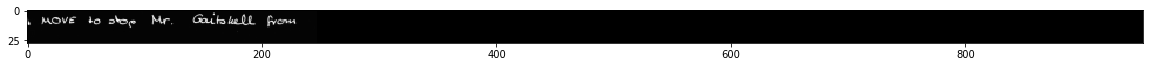

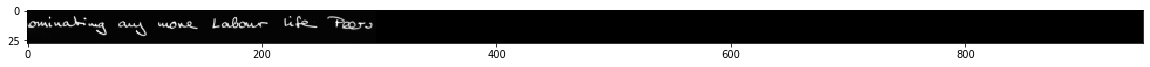

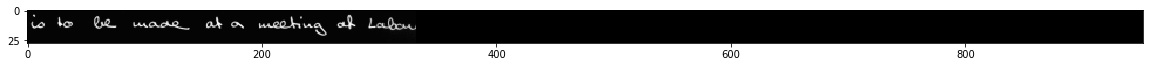

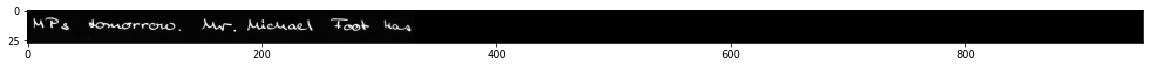

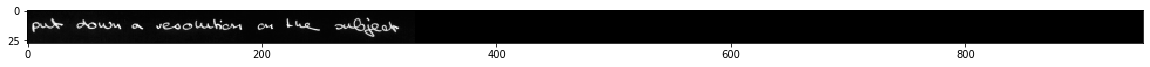

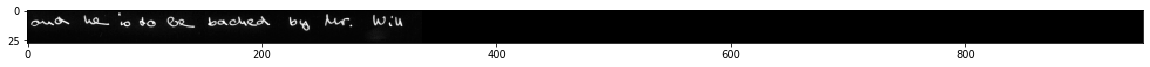

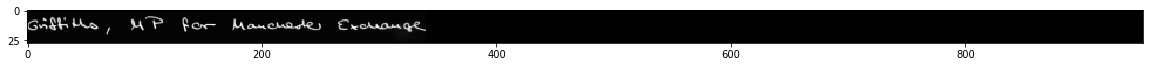

In [165]:
for cr in line_region_crops:
    c
    print(pred)
    plt.figure(figsize=(20, 15))
    plt.imshow(cr, cmap='gray')

In [174]:
cr = line_region_crops[0]
cr = _prepare_image_for_line_predictor_model(cr)
pred, conf, pred_raw = line_predictor_model.predict_on_image(cr)

In [176]:
pred_raw.shape

(80, 97)

In [179]:
pred_raw.argmax(axis=0)

array([79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79])

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [103]:
line_predictor_model.data.output_shape

(97, 80)

In [120]:
# def _helper(image, line_predictor_model):
#     if image.dtype == np.uint8:
#         image = (image / 255).astype(np.float32)
#     image = torch.from_numpy(np.expand_dims(image, 0)).to(device)
#     with torch.no_grad():
#         was_training = line_predictor_model.network.training
#         line_predictor_model.network.eval()
#         pred_raw = line_predictor_model.network(image).squeeze(dim=0).cpu().numpy()
#         if was_training:
#             line_predictor_model.network.train()
#     pred = ''.join(line_predictor_model.data.mapping[label] for label in np.argmax(pred_raw, axis=0).flatten()).strip(' |_')
#     conf = np.min(np.max(pred_raw, axis=0))  # The least confident of the predictions.
#     return pred, conf, pred_raw

In [122]:
pred_raw.shape

(80, 97)

In [123]:
pred

''

In [124]:
conf

-0.8117552

In [61]:
res = predict_crops(line_region_crops)

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [48]:
len(line_region_crops)

18

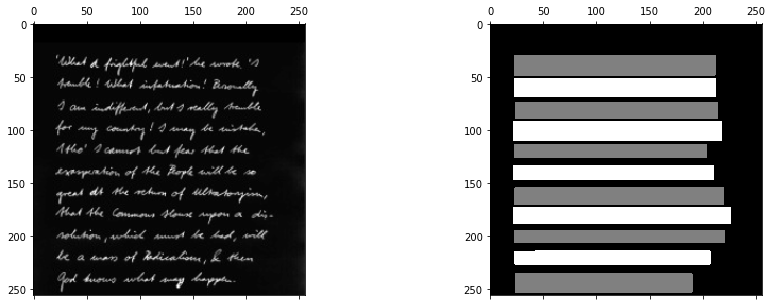

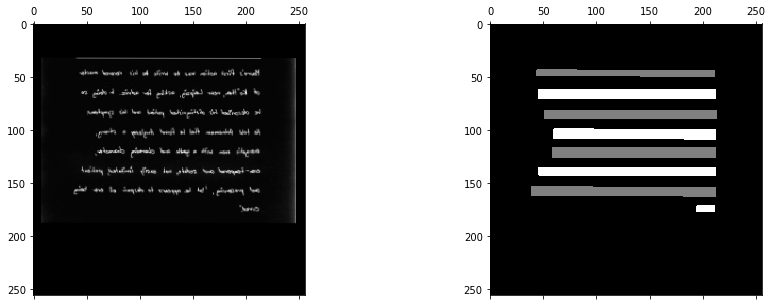

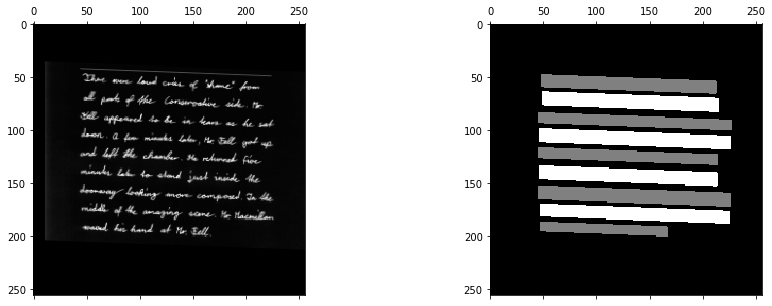

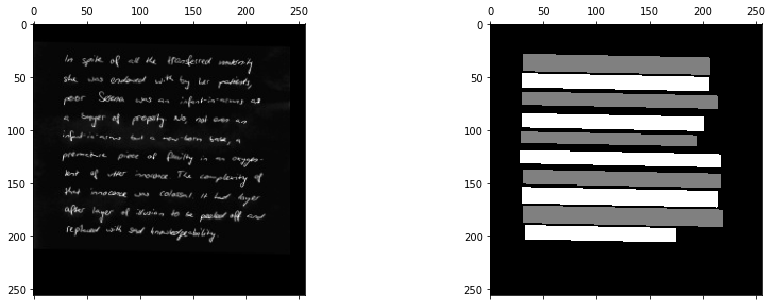

In [5]:
# Let's also look at the training data augmentations

x_batch, y_batch = paragraphs_dataset.x_train[:4], paragraphs_dataset.y_train[:4]
x_batch_aug, y_batch_aug = line_detector_model.augment_batch(x_batch, y_batch)

for ind in range(x_batch_aug.shape[0]):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.matshow(x_batch_aug[ind], cmap='gray')
    ax2 = fig.add_subplot(122)
    ax2.matshow(y_batch_aug[ind].argmax(-1), cmap='gray')